Imports and setup

In [1]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set()

%config InlineBackend.figure_format = 'svg'
plt.rcParams['figure.figsize'] = (11.7, 8.27)
plt.rcParams['image.cmap'] = 'viridis'


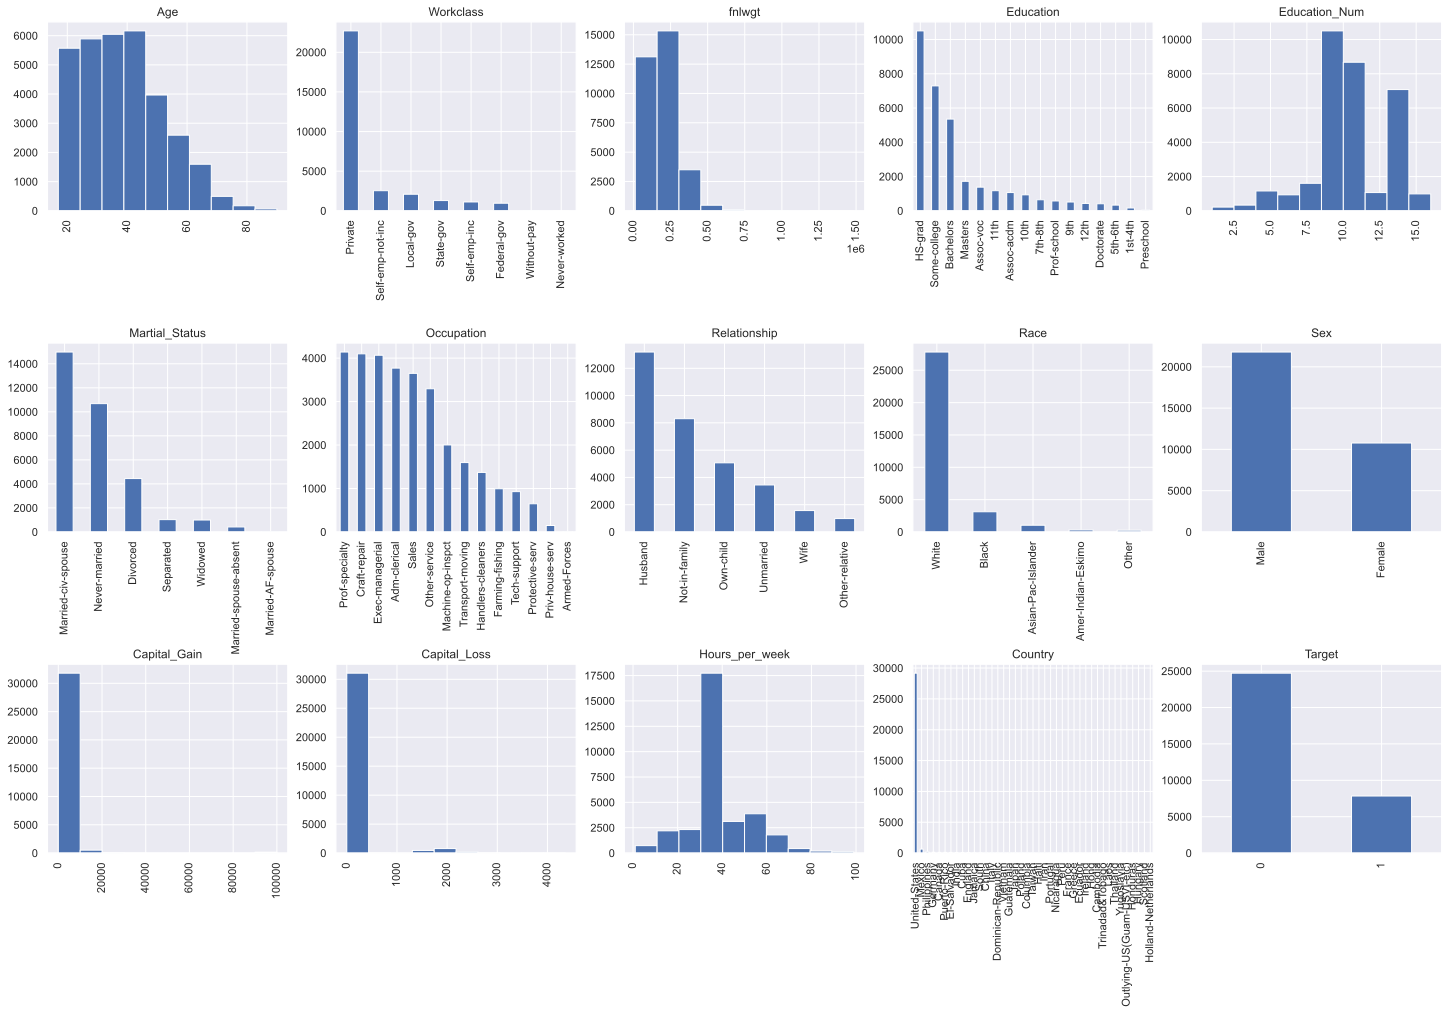

In [2]:
data_train = pd.read_csv('./adult_train.csv', sep=';')
data_test = pd.read_csv('./adult_test.csv', sep=';')
data_test = data_test[(data_test['Target'] == ' >50K.') |
                      (data_test['Target'] == ' <=50K.')]

data_train.loc[data_train['Target'] == ' <=50K', 'Target'] = 0
data_train.loc[data_train['Target'] == ' >50K', 'Target'] = 1

data_test.loc[data_test['Target'] == ' <=50K.', 'Target'] = 0
data_test.loc[data_test['Target'] == ' >50K.', 'Target'] = 1

# data_test.describe(include='all').T

fig = plt.figure(figsize=(25, 15))
cols = 5
rows = int(data_train.shape[1] / cols)
for i, column in enumerate(data_train.columns):
    ax = fig.add_subplot(rows, cols, i + 1)
    ax.set_title(column)
    if data_train.dtypes[column] == object:
        data_train[column].value_counts().plot(kind='bar', axes=ax)
    else:
        data_train[column].hist(axes=ax)
        plt.xticks(rotation='vertical')
    plt.subplots_adjust(hspace=0.7, wspace=0.2)

In [3]:
# display(data_test.dtypes)
# display(data_train.dtypes)

data_test['fnlwgt'] = data_test['fnlwgt'].astype(int)
data_test['Education_Num'] = data_test['Education_Num'].astype(int)
data_test['Capital_Gain'] = data_test['Capital_Gain'].astype(int)
data_test['Capital_Loss'] = data_test['Capital_Loss'].astype(int)
data_test['Hours_per_week'] = data_test['Hours_per_week'].astype(int)

data_train['Target'] = data_train['Target'].astype(int)
data_test['Target'] = data_test['Target'].astype(int)

y_train = data_train.pop('Target')
y_test = data_test.pop('Target')

categorical_columns = [
    col for col in data_train.columns if data_train[col].dtype.name == 'object'
]

numerical_columns = [
    col for col in data_train.columns if data_train[col].dtype.name != 'object'
]

# display(categorical_columns)
# display(numerical_columns)

for col in categorical_columns:
    data_train[col].fillna(data_train[col].mode()[0], inplace=True)
    # why fillna 'data_train' and no 'data_test'
    data_test[col].fillna(data_train[col].mode()[0], inplace=True)

for col in numerical_columns:
    data_train[col].fillna(data_train[col].median(), inplace=True)
    data_test[col].fillna(data_train[col].median(), inplace=True)

data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Age             32561 non-null  int64 
 1   Workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   Education       32561 non-null  object
 4   Education_Num   32561 non-null  int64 
 5   Martial_Status  32561 non-null  object
 6   Occupation      32561 non-null  object
 7   Relationship    32561 non-null  object
 8   Race            32561 non-null  object
 9   Sex             32561 non-null  object
 10  Capital_Gain    32561 non-null  int64 
 11  Capital_Loss    32561 non-null  int64 
 12  Hours_per_week  32561 non-null  int64 
 13  Country         32561 non-null  object
dtypes: int64(6), object(8)
memory usage: 3.5+ MB


In [4]:
data_train = pd.concat(
    [
        data_train[numerical_columns],
        pd.get_dummies(data_train[categorical_columns])
    ], axis=1)

data_test = pd.concat(
    [
        data_test[numerical_columns],
        pd.get_dummies(data_test[categorical_columns])
    ], axis=1)

In [5]:
data_test['Country_ Holland-Netherlands'] = 0
data_train['Country_ Holland-Netherlands'] = 0

X_train = data_train
X_test = data_test

In [6]:
data_test

,Age,fnlwgt,Education_Num,Capital_Gain,Capital_Loss,Hours_per_week,Workclass_ Federal-gov,Workclass_ Local-gov,Workclass_ Never-worked,Workclass_ Private,...,Country_ Puerto-Rico,Country_ Scotland,Country_ South,Country_ Taiwan,Country_ Thailand,Country_ Trinadad&Tobago,Country_ United-States,Country_ Vietnam,Country_ Yugoslavia,Country_ Holland-Netherlands
1,25,226802,7,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
2,38,89814,9,0,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,28,336951,12,0,0,40,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
4,44,160323,10,7688,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
5,18,103497,10,0,0,30,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16277,39,215419,13,0,0,36,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
16278,64,321403,9,0,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
16279,38,374983,13,0,0,50,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
16280,44,83891,13,5455,0,40,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


Task 1

In [7]:
tree = DecisionTreeClassifier(max_depth=3, random_state=17)
tree.fit(X_train, y_train)

tree_predictions = tree.predict(X_test[X_train.columns])
display(accuracy_score(y_test, tree_predictions))

0.8447884036607088

Task 2

In [8]:
tree_params = {'max_depth': range(2, 11)}

best_tree = GridSearchCV(
    DecisionTreeClassifier(random_state=17), tree_params, cv=5
)

best_tree.fit(X_train, y_train)

print(f'Best params: {best_tree.best_params_}')
print(f'Best cross validation: {best_tree.best_score_}')

Best params: {'max_depth': 9}
Best cross validation: 0.8563006429024392


In [9]:
tuned_tree = DecisionTreeClassifier(max_depth=9, random_state=17)
tuned_tree.fit(X_train, y_train)
tuned_tree_predictions = tuned_tree.predict(X_test[X_train.columns])

display(accuracy_score(y_test, tuned_tree_predictions))

0.8579939807137154